In [82]:
from skimage.io import imread
import os
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from skimage.color import gray2rgb


In [74]:
def load_nuclei_data(data_path):
    images = []
    masks = []
    root = data_path
    for subdir in tqdm(os.listdir(root)):
        subfolder = os.path.join(root,subdir)
        if os.path.isdir(subfolder):
#             print(subdir)
            for subsubfolder_name in os.listdir(subfolder):
                if subsubfolder_name == 'images':
                    for _,_,files in os.walk(os.path.join(subfolder,subsubfolder_name)):
                        for file in files:
                            if file.endswith('.png'):
                                images.append(imread(os.path.join(subfolder,subsubfolder_name,file)))
                if subsubfolder_name == 'masks':
                    for _,_,files in os.walk(os.path.join(subfolder,subsubfolder_name)):
                        mask = []
                        for file in files:
                            if file.endswith('.png'):
                                mask.append(imread(os.path.join(subfolder,subsubfolder_name,file)))
                        masks.append(mask)
    return images, masks
                    

In [75]:
train_images, train_masks = load_nuclei_data('./data/nuclei/train')
test_images,_ = load_nuclei_data('./data/nuclei/test')

print("there are %d train images"%(len(train_images)))
print("there are %d test images"%(len(test_images)))


there are 670 train images
there are 65 test images


## Note:
1. from print, we know that train images are not the same size, 4 channels-rgb+alpha. 
2. mask images are the same size as train images.

## TODO：
1. let's firstly try the simplest solution, resize them all to 256x256; **done**
2. mask could be summed together; **done**
2. better solution could be crop 256x256 from images;

In [76]:
# print("there are %d train images"%(len(train_images)))
# for image in train_images:
#     print(image.shape)

size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in tqdm(train_images)]
X = np.array(X, np.float32)
X = X[:,:,:,:-1]# we don't need this alpha channel, right?

# thresholding to get the mask
Y = np.zeros([len(train_images),X.shape[1],X.shape[2]])
k = 0
for masks in tqdm(train_masks):
    ys = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]
    ys = np.array(ys, np.float32)
    ys = ys.sum(axis=0)
    Y[k] = ys
    k += 1


ValueError: could not broadcast input array from shape (256,256,4) into shape (256,256)

In [95]:
Z = np.zeros([len(test_images),size[0],size[1],3])
print(Z.shape)
k = 0
## test image contains gray?, rgba, rgb...
for image in tqdm(test_images):
    if image.shape[2] == 1:
        image = gray2rgb(image)
        image = np.array(image, np.float32)
        image = resize(image, size, mode='constant', anti_aliasing=True)
    else:
        image = resize(image, size, mode='constant', anti_aliasing=True)
        image = np.array(image, np.float32)
    if image.shape[2] == 4:
        Z[k] = image[:,:,:-1]
    else:
        Z[k] = image
    k+=1

(65, 256, 256, 3)


(670, 256, 256, 3)


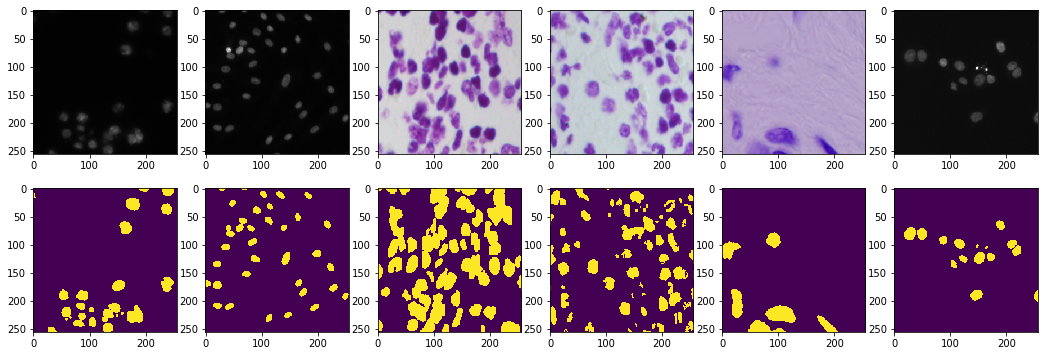

In [96]:
plt.rcParams['figure.figsize'] = [18, 6]

print(X.shape)

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.imshow(Y[i])
#     print(Y[i][Y[i] == 1])
#     break
plt.show()

In [ ]:
# split total training data
ix = np.random.choice(len(X), len(X), False)
tr, val = np.split(ix, [round(0.8*len(X))])

batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True) 
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])), 
                      batch_size=batch_size, shuffle=False)


## now, ready for sematic segmentation using DL

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)